In [ ]:
import math
import time
import tqdm
import numpy as np
import scipy as sp
import torch as th
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix

In [ ]:
def print_matrix(
    matrix: 'Matrix',
    title:'title' = None,
    n: 'Round upto' = 2,
    endl: 'End of line' ="\n",
    ) -> None:
    if title:
        print(title)
    for row in matrix:
        for col in row:
            print(str(round(col, n)).center(8 + n), end="")
        print()
    print(endl, end="")

In [ ]:
def compare_matrix(
    A: 'Matrix A',
    B: 'Matrix B',
    tol: 'Tolarence'=1e-12
    ) -> bool:
    return np.all(abs(A-B) < tol)

In [ ]:
def is_pos_def(
    x: 'Matrix x'
    ) -> bool:
    return np.all(np.linalg.eigvals(x) > 0)

In [ ]:
A = make_spd_matrix(5)
print_matrix(A, "Matrix A", endl="")
print("A is positive definite: ", is_pos_def(A), end="\n\n")
B = np.linalg.cholesky(A)
print_matrix(B, "Cholesky decomposition of A (B)")
print_matrix(np.dot(B, B.T.conj()), "B*B.T")
print("A == B*B.T = ", compare_matrix(A, np.dot(B, B.T.conj())))


Matrix A
   0.7       1.09      0.65     -0.04     -0.95   
   1.09      2.76      1.0      -0.03     -2.04   
   0.65      1.0       0.92     -0.05     -0.78   
  -0.04     -0.03     -0.05      0.58     -0.14   
  -0.95     -2.04     -0.78     -0.14      2.09   
A is positive definite:  True

Cholesky decomposition of A (B)
   0.84      0.0       0.0       0.0       0.0    
   1.3       1.04      0.0       0.0       0.0    
   0.78     -0.01      0.56      0.0       0.0    
  -0.05      0.04     -0.02      0.76      0.0    
  -1.14     -0.54      0.18     -0.23      0.64   

B*B.T
   0.7       1.09      0.65     -0.04     -0.95   
   1.09      2.76      1.0      -0.03     -2.04   
   0.65      1.0       0.92     -0.05     -0.78   
  -0.04     -0.03     -0.05      0.58     -0.14   
  -0.95     -2.04     -0.78     -0.14      2.09   

A == B*B.T =  True


In [ ]:
print_matrix(
    np.tril(A),
    "Lower triangular sub-matrix of A (including diagonal)"
    )
print_matrix(
    np.diag(np.diag(A)),
    "Diagonal of A"
    )
print_matrix(
    np.tril(A, -1),
    "Lower triangular sub-matrix of A (excluding diagonal)"
    )

Lower triangular sub-matrix of A (including diagonal)
   0.7       0.0       0.0       0.0       0.0    
   1.09      2.76      0.0       0.0       0.0    
   0.65      1.0       0.92      0.0       0.0    
  -0.04     -0.03     -0.05      0.58      0.0    
  -0.95     -2.04     -0.78     -0.14      2.09   

Diagonal of A
   0.7       0.0       0.0       0.0       0.0    
   0.0       2.76      0.0       0.0       0.0    
   0.0       0.0       0.92      0.0       0.0    
   0.0       0.0       0.0       0.58      0.0    
   0.0       0.0       0.0       0.0       2.09   

Lower triangular sub-matrix of A (excluding diagonal)
   0.0       0.0       0.0       0.0       0.0    
   1.09      0.0       0.0       0.0       0.0    
   0.65      1.0       0.0       0.0       0.0    
  -0.04     -0.03     -0.05      0.0       0.0    
  -0.95     -2.04     -0.78     -0.14      0.0    



In [ ]:
def reconstruct_cholesky_CPU(
    matrix: 'Cholesky decomposition of a matrix'
    ) -> 'Matrix':
    return np.dot(matrix, matrix.T.conj())

def reconstruct_cholesky_GPU(
    tensor: 'Cholesky decomposition of a matrix-tensor'
    ) -> 'Matrix-tensor':
    return th.mm(tensor, th.conj(th.transpose(tensor, 0, 1)))

    

def reconstruct_splitting_1_CPU(
    matrix: 'lower triangular matrix with diagonal'
    ) -> 'Matrix':
    _temp = np.zeros(shape=matrix.shape, dtype=matrix.dtype)
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if i >= j:
                _temp[i][j] = matrix[i][j]
            else:
                _temp[i][j] = matrix[j][i]
    return _temp


def reconstruct_splitting_2_CPU(
    matrix: 'lower triangular matrix with/without diagonal',
    D: 'diagonal'
    ) -> 'Matrix':
    _temp = np.zeros(shape=matrix.shape, dtype=matrix.dtype)
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if i > j:
                _temp[i][j] = matrix[i][j]
            elif i == j:
                _temp[i][j] = D[i][j]
            else:
                _temp[i][j] = matrix[j][i]
    return _temp


def reconstruct_splitting_1_GPU(
    matrix: 'lower triangular matrix with diagonal'
    ) -> 'Matrix':
    _temp = matrix + matrix.T
    for i in range(len(matrix)):
        _temp[i][i] /= 2

def reconstruct_splitting_2_GPU(
    matrix: 'lower triangular matrix with diagonal',
    D: 'diagonal'
    ) -> 'Matrix':
    return matrix + matrix.T - D

def reconstruct_splitting_3_GPU(
    matrix: 'lower triangular matrix without diagonal',
    D: 'diagonal'
    ) -> 'Matrix':
    return matrix + matrix.T + D

def reconstruct_splitting_1_GPU_CUDA(
    tensor: 'lower triangular matrix-tensor with diagonal'
    ) -> 'Matrix':
    _temp = tensor + th.transpose(tensor, 0, 1)
    for i in range(len(tensor)):
        _temp[i][i] /= 2

def reconstruct_splitting_2_GPU_CUDA(
    tensor: 'lower triangular matrix-tensor with diagonal',
    D: 'diagonal-tensor'
    ) -> 'Matrix':
    return tensor + th.transpose(tensor, 0, 1) - D

def reconstruct_splitting_3_GPU_CUDA(
    tensor: 'lower triangular matrix-tensor without diagonal',
    D: 'diagonal'
    ) -> 'Matrix':
    return tensor + th.transpose(tensor, 0, 1) + D


n, iterations completed: 100%|██████████| 501/501 [01:52<00:00,  4.45it/s]


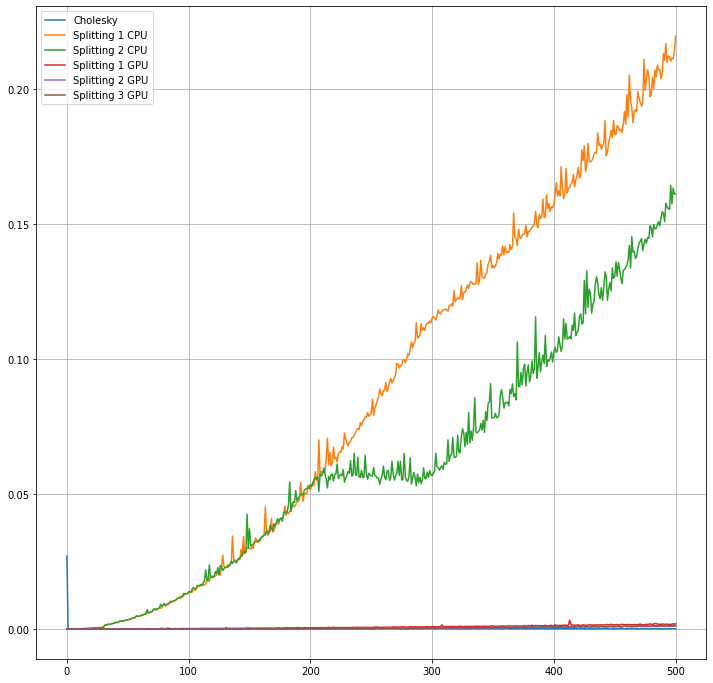

In [ ]:
N = 500
cholesky_time = np.zeros(N+1, dtype=np.float64)
splitting_time_1_CPU = np.zeros(N+1, dtype=np.float64)
splitting_time_2_CPU = np.zeros(N+1, dtype=np.float64)
splitting_time_1_GPU = np.zeros(N+1, dtype=np.float64)
splitting_time_2_GPU = np.zeros(N+1, dtype=np.float64)
splitting_time_3_GPU = np.zeros(N+1, dtype=np.float64)

if th.cuda.is_available():

    for n in tqdm.tqdm(
        iterable=range(2, N + 3),
        desc="n, iterations completed",
        leave=True,
        position=0,
        ):
        A = make_spd_matrix(n)
        B = np.linalg.cholesky(A)
        LD = np.triu(A)
        D = np.diag(np.diag(A))
        L = np.triu(A, -1)
        B_tensor = th.FloatTensor(B).to("cuda")


        Mark1 = time.time()
        A_cholesky = reconstruct_cholesky_GPU(B_tensor)
        Mark1_end = time.time()
        cholesky_time[n-2] = Mark1_end - Mark1

        Mark2 = time.time()
        A_splitting_1 = reconstruct_splitting_1_GPU(LD)
        Mark2_end = time.time()
        splitting_time_1_GPU[n-2] = Mark2_end - Mark2

        Mark3 = time.time()
        A_splitting_1 = reconstruct_splitting_2_GPU(LD, D)
        Mark3_end = time.time()
        splitting_time_2_GPU[n-2] = Mark3_end - Mark3

        Mark4 = time.time()
        A_splitting_1 = reconstruct_splitting_3_GPU(L, D)
        Mark4_end = time.time()
        splitting_time_3_GPU[n-2] = Mark4_end - Mark4

        Mark5 = time.time()
        A_splitting_1 = reconstruct_splitting_1_CPU(LD)
        Mark5_end = time.time()
        splitting_time_1_CPU[n-2] = Mark5_end - Mark5

        Mark6 = time.time()
        A_splitting_1 = reconstruct_splitting_2_CPU(LD, D)
        Mark6_end = time.time()
        splitting_time_2_CPU[n-2] = Mark6_end - Mark6

    plt.figure(figsize=(12, 12))
    plt.plot(cholesky_time, label="Cholesky")
    plt.plot(splitting_time_1_CPU, label="Splitting 1 CPU")
    plt.plot(splitting_time_2_CPU, label="Splitting 2 CPU")
    plt.plot(splitting_time_1_GPU, label="Splitting 1 GPU")
    plt.plot(splitting_time_2_GPU, label="Splitting 2 GPU")
    plt.plot(splitting_time_3_GPU, label="Splitting 3 GPU")
    plt.legend()
    plt.grid()
else:
    print(
        "You need to enable GPU accelaration in colab",
        "(runtime->change runtime type)"
        )

n, iterations completed: 100%|██████████| 1001/1001 [04:38<00:00,  3.59it/s]


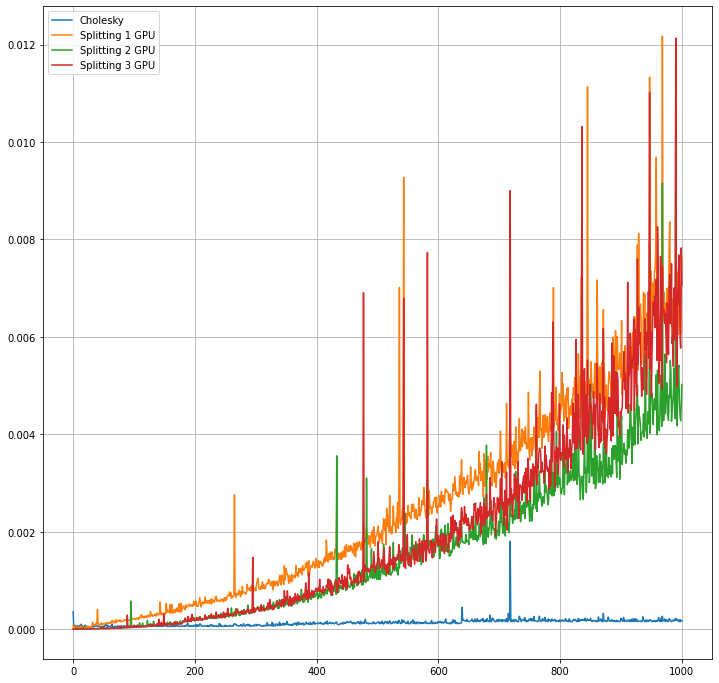

In [ ]:
N = 1000
cholesky_time = np.zeros(N+1, dtype=np.float64)
splitting_time_1_GPU = np.zeros(N+1, dtype=np.float64)
splitting_time_2_GPU = np.zeros(N+1, dtype=np.float64)
splitting_time_3_GPU = np.zeros(N+1, dtype=np.float64)

if th.cuda.is_available():

    for n in tqdm.tqdm(
        iterable=range(2, N + 3),
        desc="n, iterations completed",
        leave=True,
        position=0,
        ):
        A = make_spd_matrix(n)
        B = np.linalg.cholesky(A)
        LD = np.triu(A)
        D = np.diag(np.diag(A))
        L = np.triu(A, -1)
        B_tensor = th.FloatTensor(B).to("cuda")


        Mark1 = time.time()
        A_cholesky = reconstruct_cholesky_GPU(B_tensor)
        Mark1_end = time.time()
        cholesky_time[n-2] = Mark1_end - Mark1

        Mark2 = time.time()
        A_splitting_1 = reconstruct_splitting_1_GPU(LD)
        Mark2_end = time.time()
        splitting_time_1_GPU[n-2] = Mark2_end - Mark2

        Mark3 = time.time()
        A_splitting_1 = reconstruct_splitting_2_GPU(LD, D)
        Mark3_end = time.time()
        splitting_time_2_GPU[n-2] = Mark3_end - Mark3

        Mark4 = time.time()
        A_splitting_1 = reconstruct_splitting_3_GPU(L, D)
        Mark4_end = time.time()
        splitting_time_3_GPU[n-2] = Mark4_end - Mark4


    plt.figure(figsize=(12, 12))
    plt.plot(cholesky_time, label="Cholesky")
    plt.plot(splitting_time_1_GPU, label="Splitting 1 GPU")
    plt.plot(splitting_time_2_GPU, label="Splitting 2 GPU")
    plt.plot(splitting_time_3_GPU, label="Splitting 3 GPU")
    plt.legend()
    plt.grid()
else:
    print(
        "You need to enable GPU accelaration in colab",
        "(runtime->change runtime type)"
        )

n, iterations completed: 100%|██████████| 501/501 [00:32<00:00, 15.37it/s]


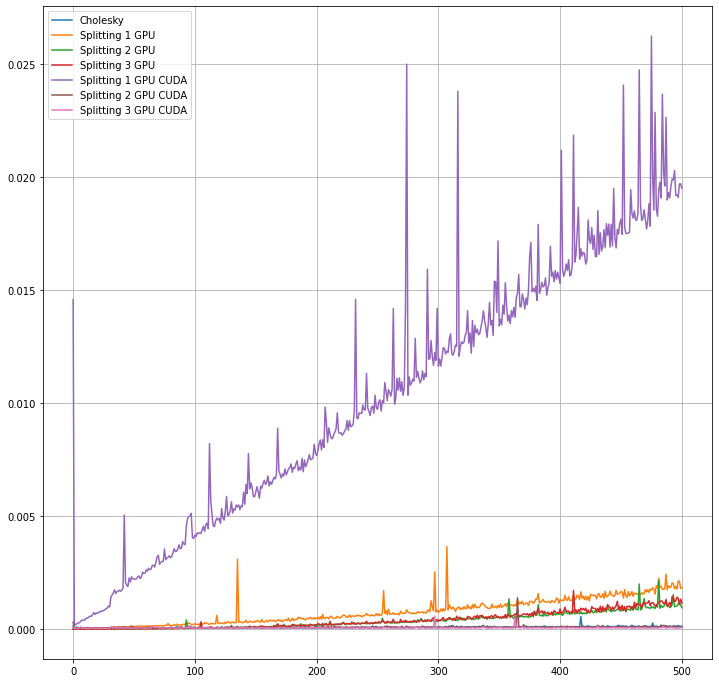

In [ ]:
N = 500
cholesky_time = np.zeros(N+1, dtype=np.float64)

splitting_time_1_GPU = np.zeros(N+1, dtype=np.float64)
splitting_time_2_GPU = np.zeros(N+1, dtype=np.float64)
splitting_time_3_GPU = np.zeros(N+1, dtype=np.float64)

splitting_time_1_GPU_CUDA = np.zeros(N+1, dtype=np.float64)
splitting_time_2_GPU_CUDA = np.zeros(N+1, dtype=np.float64)
splitting_time_3_GPU_CUDA = np.zeros(N+1, dtype=np.float64)

if th.cuda.is_available():

    for n in tqdm.tqdm(
        iterable=range(2, N + 3),
        desc="n, iterations completed",
        leave=True,
        position=0,
        ):
        A = make_spd_matrix(n)
        B = np.linalg.cholesky(A)
        LD = np.triu(A)
        D = np.diag(np.diag(A))
        L = np.triu(A, -1)
        B_tensor = th.FloatTensor(B).to("cuda")
        LD_tensor = th.FloatTensor(LD).to("cuda")
        L_tensor = th.FloatTensor(L).to("cuda")
        D_tensor = th.FloatTensor(D).to("cuda")


        Mark1 = time.time()
        A_cholesky = reconstruct_cholesky_GPU(B_tensor)
        Mark1_end = time.time()
        cholesky_time[n-2] = Mark1_end - Mark1

        Mark2 = time.time()
        A_splitting_1 = reconstruct_splitting_1_GPU(LD)
        Mark2_end = time.time()
        splitting_time_1_GPU[n-2] = Mark2_end - Mark2

        Mark3 = time.time()
        A_splitting_1 = reconstruct_splitting_2_GPU(LD, D)
        Mark3_end = time.time()
        splitting_time_2_GPU[n-2] = Mark3_end - Mark3

        Mark4 = time.time()
        A_splitting_1 = reconstruct_splitting_3_GPU(L, D)
        Mark4_end = time.time()
        splitting_time_3_GPU[n-2] = Mark4_end - Mark4

        Mark5 = time.time()
        A_splitting_1 = reconstruct_splitting_1_GPU_CUDA(LD_tensor)
        Mark5_end = time.time()
        splitting_time_1_GPU_CUDA[n-2] = Mark5_end - Mark5

        Mark6 = time.time()
        A_splitting_1 = reconstruct_splitting_2_GPU_CUDA(LD_tensor, D_tensor)
        Mark6_end = time.time()
        splitting_time_2_GPU_CUDA[n-2] = Mark6_end - Mark6

        Mark7 = time.time()
        A_splitting_1 = reconstruct_splitting_3_GPU_CUDA(L_tensor, D_tensor)
        Mark7_end = time.time()
        splitting_time_3_GPU_CUDA[n-2] = Mark7_end - Mark7


    plt.figure(figsize=(12, 12))
    plt.plot(cholesky_time, label="Cholesky")
    plt.plot(splitting_time_1_GPU, label="Splitting 1 GPU")
    plt.plot(splitting_time_2_GPU, label="Splitting 2 GPU")
    plt.plot(splitting_time_3_GPU, label="Splitting 3 GPU")
    plt.plot(splitting_time_1_GPU_CUDA, label="Splitting 1 GPU CUDA")
    plt.plot(splitting_time_2_GPU_CUDA, label="Splitting 2 GPU CUDA")
    plt.plot(splitting_time_3_GPU_CUDA, label="Splitting 3 GPU CUDA")
    plt.legend()
    plt.grid()
else:
    print(
        "You need to enable GPU accelaration in colab",
        "(runtime->change runtime type)"
        )

n, iterations completed: 100%|██████████| 501/501 [00:32<00:00, 15.54it/s]


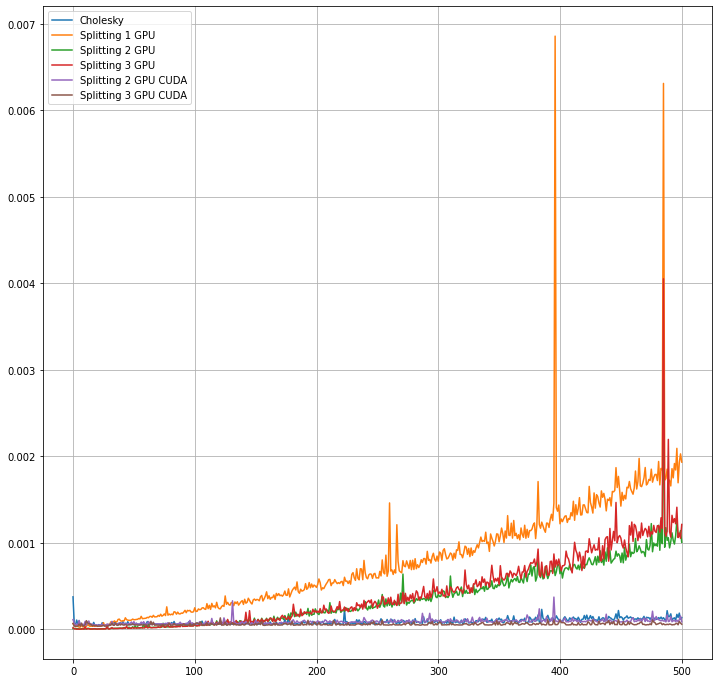

In [ ]:
N = 500
cholesky_time = np.zeros(N+1, dtype=np.float64)

splitting_time_1_GPU = np.zeros(N+1, dtype=np.float64)
splitting_time_2_GPU = np.zeros(N+1, dtype=np.float64)
splitting_time_3_GPU = np.zeros(N+1, dtype=np.float64)

splitting_time_1_GPU_CUDA = np.zeros(N+1, dtype=np.float64)
splitting_time_2_GPU_CUDA = np.zeros(N+1, dtype=np.float64)
splitting_time_3_GPU_CUDA = np.zeros(N+1, dtype=np.float64)

if th.cuda.is_available():

    for n in tqdm.tqdm(
        iterable=range(2, N + 3),
        desc="n, iterations completed",
        leave=True,
        position=0,
        ):
        A = make_spd_matrix(n)
        B = np.linalg.cholesky(A)
        LD = np.triu(A)
        D = np.diag(np.diag(A))
        L = np.triu(A, -1)
        B_tensor = th.FloatTensor(B).to("cuda")
        LD_tensor = th.FloatTensor(LD).to("cuda")
        L_tensor = th.FloatTensor(L).to("cuda")
        D_tensor = th.FloatTensor(D).to("cuda")


        Mark1 = time.time()
        A_cholesky = reconstruct_cholesky_GPU(B_tensor)
        Mark1_end = time.time()
        cholesky_time[n-2] = Mark1_end - Mark1

        Mark2 = time.time()
        A_splitting_1 = reconstruct_splitting_1_GPU(LD)
        Mark2_end = time.time()
        splitting_time_1_GPU[n-2] = Mark2_end - Mark2

        Mark3 = time.time()
        A_splitting_1 = reconstruct_splitting_2_GPU(LD, D)
        Mark3_end = time.time()
        splitting_time_2_GPU[n-2] = Mark3_end - Mark3

        Mark4 = time.time()
        A_splitting_1 = reconstruct_splitting_3_GPU(L, D)
        Mark4_end = time.time()
        splitting_time_3_GPU[n-2] = Mark4_end - Mark4

        Mark5 = time.time()
        A_splitting_1 = reconstruct_splitting_1_GPU_CUDA(LD_tensor)
        Mark5_end = time.time()
        splitting_time_1_GPU_CUDA[n-2] = Mark5_end - Mark5

        Mark6 = time.time()
        A_splitting_1 = reconstruct_splitting_2_GPU_CUDA(LD_tensor, D_tensor)
        Mark6_end = time.time()
        splitting_time_2_GPU_CUDA[n-2] = Mark6_end - Mark6

        Mark7 = time.time()
        A_splitting_1 = reconstruct_splitting_3_GPU_CUDA(L_tensor, D_tensor)
        Mark7_end = time.time()
        splitting_time_3_GPU_CUDA[n-2] = Mark7_end - Mark7


    plt.figure(figsize=(12, 12))
    plt.plot(cholesky_time, label="Cholesky")
    plt.plot(splitting_time_1_GPU, label="Splitting 1 GPU")
    plt.plot(splitting_time_2_GPU, label="Splitting 2 GPU")
    plt.plot(splitting_time_3_GPU, label="Splitting 3 GPU")
    plt.plot(splitting_time_2_GPU_CUDA, label="Splitting 2 GPU CUDA")
    plt.plot(splitting_time_3_GPU_CUDA, label="Splitting 3 GPU CUDA")
    plt.legend()
    plt.grid()
else:
    print(
        "You need to enable GPU accelaration in colab",
        "(runtime->change runtime type)"
        )

n, iterations completed: 100%|██████████| 501/501 [00:31<00:00, 15.81it/s]


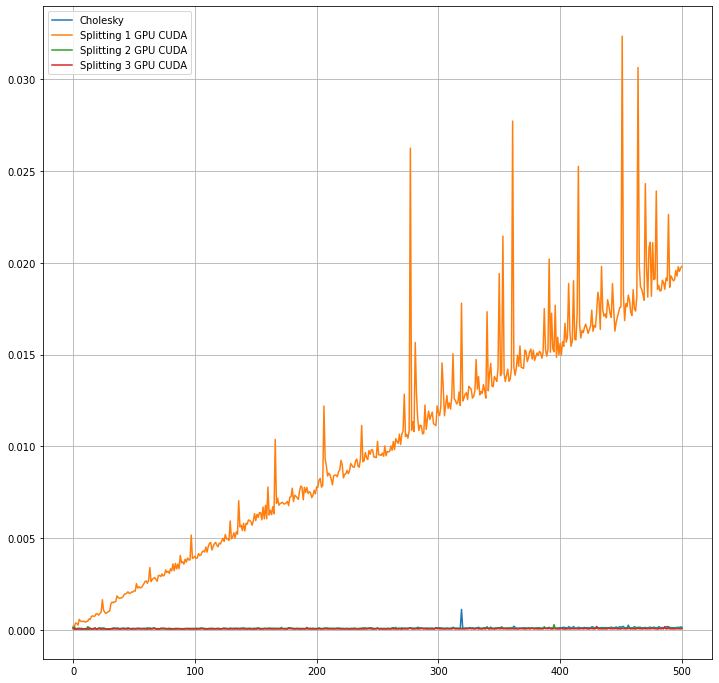

In [ ]:
N = 500
cholesky_time = np.zeros(N+1, dtype=np.float64)

splitting_time_1_GPU_CUDA = np.zeros(N+1, dtype=np.float64)
splitting_time_2_GPU_CUDA = np.zeros(N+1, dtype=np.float64)
splitting_time_3_GPU_CUDA = np.zeros(N+1, dtype=np.float64)

if th.cuda.is_available():

    for n in tqdm.tqdm(
        iterable=range(2, N + 3),
        desc="n, iterations completed",
        leave=True,
        position=0,
        ):
        A = make_spd_matrix(n)
        B = np.linalg.cholesky(A)
        LD = np.triu(A)
        D = np.diag(np.diag(A))
        L = np.triu(A, -1)
        B_tensor = th.FloatTensor(B).to("cuda")
        LD_tensor = th.FloatTensor(LD).to("cuda")
        L_tensor = th.FloatTensor(L).to("cuda")
        D_tensor = th.FloatTensor(D).to("cuda")


        Mark1 = time.time()
        A_cholesky = reconstruct_cholesky_GPU(B_tensor)
        Mark1_end = time.time()
        cholesky_time[n-2] = Mark1_end - Mark1

        Mark5 = time.time()
        A_splitting_1 = reconstruct_splitting_1_GPU_CUDA(LD_tensor)
        Mark5_end = time.time()
        splitting_time_1_GPU_CUDA[n-2] = Mark5_end - Mark5

        Mark6 = time.time()
        A_splitting_1 = reconstruct_splitting_2_GPU_CUDA(LD_tensor, D_tensor)
        Mark6_end = time.time()
        splitting_time_2_GPU_CUDA[n-2] = Mark6_end - Mark6

        Mark7 = time.time()
        A_splitting_1 = reconstruct_splitting_3_GPU_CUDA(L_tensor, D_tensor)
        Mark7_end = time.time()
        splitting_time_3_GPU_CUDA[n-2] = Mark7_end - Mark7


    plt.figure(figsize=(12, 12))
    plt.plot(cholesky_time, label="Cholesky")
    plt.plot(splitting_time_1_GPU_CUDA, label="Splitting 1 GPU CUDA")
    plt.plot(splitting_time_2_GPU_CUDA, label="Splitting 2 GPU CUDA")
    plt.plot(splitting_time_3_GPU_CUDA, label="Splitting 3 GPU CUDA")
    plt.legend()
    plt.grid()
else:
    print(
        "You need to enable GPU accelaration in colab",
        "(runtime->change runtime type)"
        )

n, iterations completed: 100%|██████████| 1001/1001 [04:09<00:00,  4.01it/s]


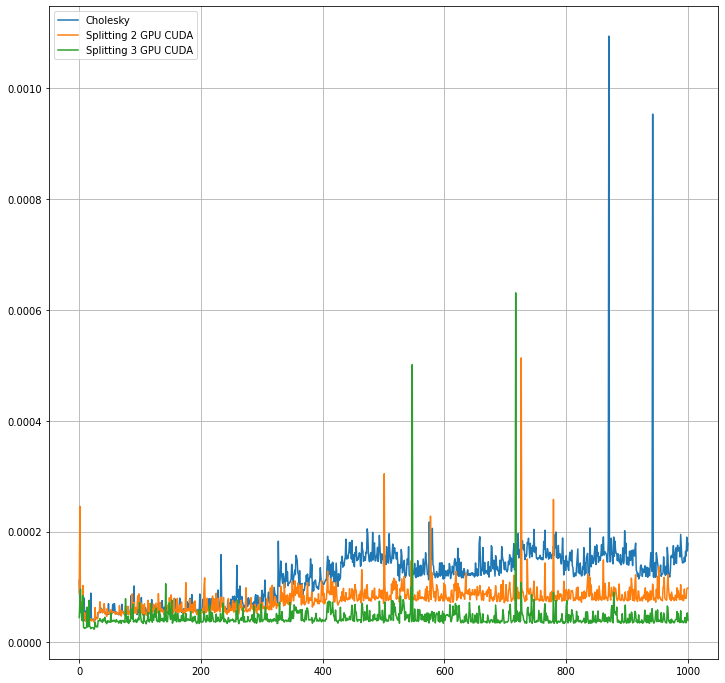

In [ ]:
N = 1000
cholesky_time = np.zeros(N+1, dtype=np.float64)

splitting_time_2_GPU_CUDA = np.zeros(N+1, dtype=np.float64)
splitting_time_3_GPU_CUDA = np.zeros(N+1, dtype=np.float64)

if th.cuda.is_available():

    for n in tqdm.tqdm(
        iterable=range(2, N + 3),
        desc="n, iterations completed",
        leave=True,
        position=0,
        ):
        A = make_spd_matrix(n)
        B = np.linalg.cholesky(A)
        LD = np.triu(A)
        D = np.diag(np.diag(A))
        L = np.triu(A, -1)
        B_tensor = th.FloatTensor(B).to("cuda")
        LD_tensor = th.FloatTensor(LD).to("cuda")
        L_tensor = th.FloatTensor(L).to("cuda")
        D_tensor = th.FloatTensor(D).to("cuda")


        Mark1 = time.time()
        A_cholesky = reconstruct_cholesky_GPU(B_tensor)
        Mark1_end = time.time()
        cholesky_time[n-2] = Mark1_end - Mark1
    
        Mark6 = time.time()
        A_splitting_1 = reconstruct_splitting_2_GPU_CUDA(LD_tensor, D_tensor)
        Mark6_end = time.time()
        splitting_time_2_GPU_CUDA[n-2] = Mark6_end - Mark6

        Mark7 = time.time()
        A_splitting_1 = reconstruct_splitting_3_GPU_CUDA(L_tensor, D_tensor)
        Mark7_end = time.time()
        splitting_time_3_GPU_CUDA[n-2] = Mark7_end - Mark7


    plt.figure(figsize=(12, 12))
    plt.plot(cholesky_time, label="Cholesky")
    plt.plot(splitting_time_2_GPU_CUDA, label="Splitting 2 GPU CUDA")
    plt.plot(splitting_time_3_GPU_CUDA, label="Splitting 3 GPU CUDA")
    plt.legend()
    plt.grid()
else:
    print(
        "You need to enable GPU accelaration in colab",
        "(runtime->change runtime type)"
        )

n, iterations completed: 100%|██████████| 301/301 [05:50<00:00,  1.16s/it]


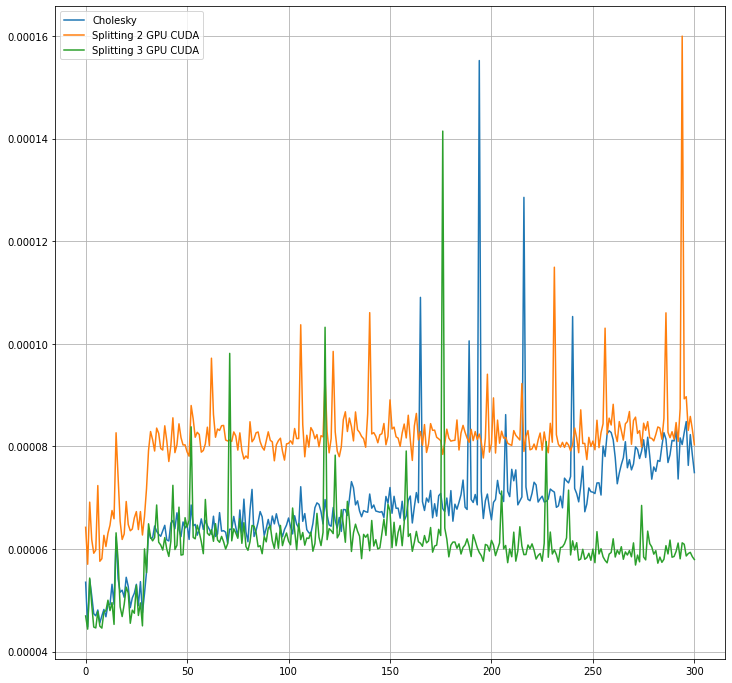

In [ ]:
N = 300
smth = 70
cholesky_time = np.zeros(N+1, dtype=np.float64)

splitting_time_2_GPU_CUDA = np.zeros(N+1, dtype=np.float64)
splitting_time_3_GPU_CUDA = np.zeros(N+1, dtype=np.float64)

if th.cuda.is_available():

    for n in tqdm.tqdm(
        iterable=range(2, N + 3),
        desc="n, iterations completed",
        leave=True,
        position=0,
        ):
        for _ in range(smth):
            A = make_spd_matrix(n)
            B = np.linalg.cholesky(A)
            LD = np.triu(A)
            D = np.diag(np.diag(A))
            L = np.triu(A, -1)
            B_tensor = th.FloatTensor(B).to("cuda")
            LD_tensor = th.FloatTensor(LD).to("cuda")
            L_tensor = th.FloatTensor(L).to("cuda")
            D_tensor = th.FloatTensor(D).to("cuda")


            Mark1 = time.time()
            A_cholesky = reconstruct_cholesky_GPU(B_tensor)
            Mark1_end = time.time()
            cholesky_time[n-2] += Mark1_end - Mark1

            Mark6 = time.time()
            A_splitting_1 = reconstruct_splitting_2_GPU_CUDA(LD_tensor, D_tensor)
            Mark6_end = time.time()
            splitting_time_2_GPU_CUDA[n-2] += Mark6_end - Mark6

            Mark7 = time.time()
            A_splitting_1 = reconstruct_splitting_3_GPU_CUDA(L_tensor, D_tensor)
            Mark7_end = time.time()
            splitting_time_3_GPU_CUDA[n-2] += Mark7_end - Mark7
        cholesky_time[n-2] /= smth
        splitting_time_2_GPU_CUDA[n-2] /= smth
        splitting_time_3_GPU_CUDA[n-2] /= smth



    plt.figure(figsize=(12, 12))
    plt.plot(cholesky_time, label="Cholesky")
    plt.plot(splitting_time_2_GPU_CUDA, label="Splitting 2 GPU CUDA")
    plt.plot(splitting_time_3_GPU_CUDA, label="Splitting 3 GPU CUDA")
    plt.legend()
    plt.grid()
else:
    print(
        "You need to enable GPU accelaration in colab",
        "(runtime->change runtime type)"
        )